In [48]:
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBRFClassifier
from imblearn.ensemble import RUSBoostClassifier


In [34]:
df = pd.read_csv('sample_processed.csv')
df.head()

,CLIENT_ID,TARGET,l_1,l_2,l_3,l_4,l_5,l_6,l_7,l_8,...,l_46,l_47,total_visits_domain,n1_active_days_domain,n2_active_days_domain,n3_active_days_domain,average_visits_per_day_domain,visits_1_day_ago_domain,visits_2_day_ago_domain,visits_3_day_ago_domain
0,u_1,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,NaN,0,0,1
1,u_2,0,0,0,0,0,0,0,0,0,...,0,0,5,2,1,0,2.5,2,0,0
2,u_3,0,0,0,0,0,0,0,0,0,...,0,0,3,1,0,0,2.0,0,2,0
3,u_4,0,0,0,0,0,0,0,0,0,...,0,0,13,2,1,1,5.0,0,1,0
4,u_5,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,NaN,0,0,0


In [35]:
print('df shape: ', df.shape)
df.isna().sum().sort_values(ascending=False)[:5]

df shape:  (2905, 57)


average_visits_per_day_domain    1244
CLIENT_ID                           0
l_41                                0
l_30                                0
l_31                                0
dtype: int64

Только в одном столбце много НаНов. Причем это столбец по среднему числу визитов. Непонятно, чем его заполнять, заполним 0, чтобы отличать таких пользователей (все остальные значения в этом столбце больше 0).

In [36]:
df.average_visits_per_day_domain.fillna(0, inplace=True)

#### Train-Test-Split

In [37]:
X = df.drop(['CLIENT_ID', 'TARGET'], axis=1).values
y = df.TARGET.values

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

In [39]:
print(X_train.shape, X_test.shape)
print(Counter(y_train))
print(Counter(y_test))

(2033, 55) (872, 55)
Counter({0: 1994, 1: 39})
Counter({0: 855, 1: 17})


#### Очень маленький процент Target=1 

********************
Logistic Regression
********************
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       855
           1       0.00      0.00      0.00        17

    accuracy                           0.98       872
   macro avg       0.49      0.50      0.49       872
weighted avg       0.96      0.98      0.97       872



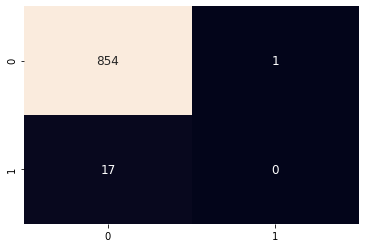

In [40]:
model_LR = LogisticRegression().fit(X_train, y_train)
preds_LR = model_LR.predict(X_test)
prob_preds_LR = model_LR.predict_proba(X_test)[::,1]

print('*'*20)
print("Logistic Regression")
print('*'*20)
print(classification_report(y_test, preds_LR,zero_division=1))
sns.heatmap(confusion_matrix(y_test, preds_LR), annot=True, annot_kws={"size": 12}, fmt='g', cbar=False);

********************
Balanced Random Forest
********************
              precision    recall  f1-score   support

           0       0.99      0.51      0.67       855
           1       0.03      0.65      0.05        17

    accuracy                           0.51       872
   macro avg       0.51      0.58      0.36       872
weighted avg       0.97      0.51      0.66       872



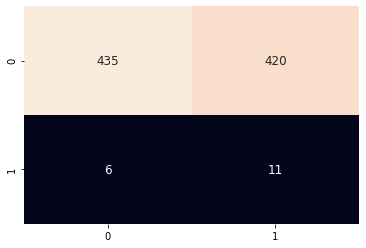

In [41]:
model_BRF = BalancedRandomForestClassifier().fit(X_train, y_train)
preds_BRF = model_BRF.predict(X_test)
prob_preds_BRF = model_BRF.predict_proba(X_test)[::,1]

print('*'*20)
print("Balanced Random Forest")
print('*'*20)
print(classification_report(y_test, preds_BRF, zero_division=1))
sns.heatmap(confusion_matrix(y_test, preds_BRF), annot=True, annot_kws={"size": 12}, fmt='g', cbar=False);

********************
Imblearn RUSBoost
********************
              precision    recall  f1-score   support

           0       0.99      0.56      0.72       855
           1       0.03      0.76      0.06        17

    accuracy                           0.56       872
   macro avg       0.51      0.66      0.39       872
weighted avg       0.97      0.56      0.70       872



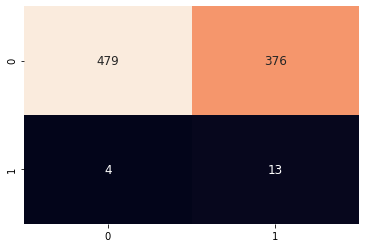

In [42]:
model_RUSBoost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',
                                    random_state=0).fit(X_train, y_train)

preds_RUSBoost = model_RUSBoost.predict(X_test)
prob_preds_RUSBoost = model_RUSBoost.predict_proba(X_test)[::,1]

print('*'*20)
print("Imblearn RUSBoost")
print('*'*20)
print(classification_report(y_test, preds_RUSBoost, zero_division=1))
sns.heatmap(confusion_matrix(y_test, preds_RUSBoost), annot=True, annot_kws={"size": 12}, fmt='g', cbar=False);

In [43]:
1 / y_train.mean()

52.128205128205124

[17:38:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
********************
Random Forest
********************
              precision    recall  f1-score   support

           0       0.99      0.67      0.80       855
           1       0.03      0.59      0.07        17

    accuracy                           0.67       872
   macro avg       0.51      0.63      0.43       872
weighted avg       0.97      0.67      0.79       872



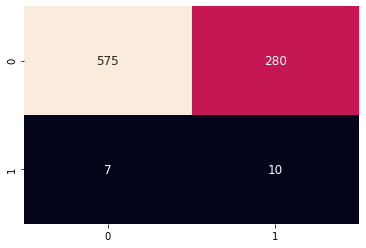

In [44]:
model_XGB = XGBRFClassifier(scale_pos_weight=50, use_label_encoder=False).fit(X_train, y_train)
preds_XGB = model_XGB.predict(X_test)
prob_preds_XGB = model_XGB.predict_proba(X_test)[::,1]

print('*'*20)
print("XGB Classifier")
print('*'*20)
print(classification_report(y_test, preds_XGB, zero_division=1))
sns.heatmap(confusion_matrix(y_test, preds_XGB), annot=True, annot_kws={"size": 12}, fmt='g', cbar=False);

********************
RF Classifier
********************
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       855
           1       0.03      0.29      0.06        17

    accuracy                           0.82       872
   macro avg       0.51      0.56      0.48       872
weighted avg       0.96      0.82      0.88       872



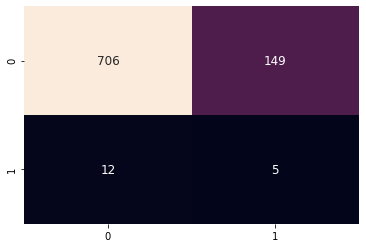

In [46]:
model_RF = RandomForestClassifier(class_weight="balanced_subsample").fit(X_train, y_train)
preds_RF = model_RF.predict(X_test)
prob_preds_RF = model_RF.predict_proba(X_test)[::,1]

print('*'*20)
print("RF Classifier")
print('*'*20)
print(classification_report(y_test, preds_RF, zero_division=1))
sns.heatmap(confusion_matrix(y_test, preds_RF), annot=True, annot_kws={"size": 12}, fmt='g', cbar=False);

               model ROC_AUC
    LinearRegression 0.6424148606811145
BalancedRandomForest 0.6158582731338149
        RandomForest 0.6543171654626763
             XGBoost 0.6858617131062952
 Imbalanced RUSBoost 0.6542139662882697


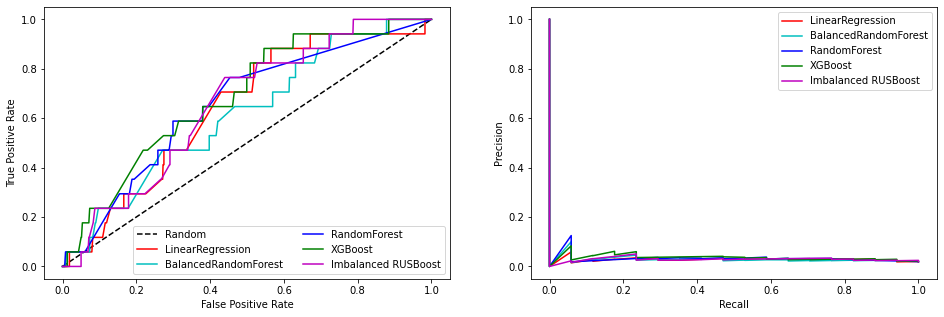

In [51]:
_, ax = plt.subplots(1, 2, figsize=(16, 5))

models = ['LinearRegression', 'BalancedRandomForest', 'RandomForest', 'XGBoost', 'Imbalanced RUSBoost']
preds = [prob_preds_LR, prob_preds_BRF, prob_preds_RF, prob_preds_XGB, prob_preds_RUSBoost]
colors = 'rcbgm'

ax[0].plot([0, 1], [0, 1], ls='--', label='Random', c='k')

print(f"{'model':>20} {'ROC_AUC'}")
for model, pred, c in zip(models, preds, colors):
    print(f"{model:>20} {roc_auc_score(y_test, pred)}")
    fpr, tpr, _ = roc_curve(y_test, pred)
    ax[0].plot(fpr, tpr, label=model, c=c)
    
    precision, recall, thresholds = precision_recall_curve(y_test, pred)
    ax[1].plot(recall, precision, label=model, c=c)


ax[0].set_ylabel('True Positive Rate')
ax[0].set_xlabel('False Positive Rate')
ax[1].set_ylabel('Precision')
ax[1].set_xlabel('Recall')

ax[0].legend(ncol=2)
ax[1].legend()

In [62]:
plt.rcParams.update({'font.size': 12})


<AxesSubplot:>

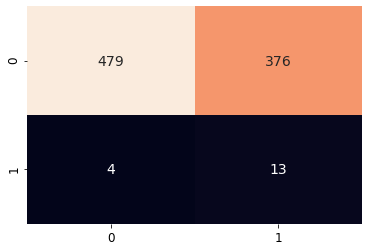

In [63]:
sns.heatmap(confusion_matrix(y_test, preds_RUSBoost), annot=True, annot_kws={"fontsize": 14}, fmt='g', cbar=False)
